<a href="https://colab.research.google.com/github/mishabar410/ML-2022/blob/main/diffusion_pokemons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images. I will explain all the theoretical details in the YouTube video. 


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


## Investigating the dataset

As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download hlrhegemony/pokemon-image-dataset -p /content/sample_data/ --unzip

Saving kaggle.json to kaggle.json
 78% 45.0M/57.9M [00:00<00:00, 146MB/s]
100% 57.9M/57.9M [00:00<00:00, 119MB/s]


In [2]:
import torchvision.datasets as dset

dataroot = '/content/sample_data/images'

data = dset.ImageFolder(root=dataroot)

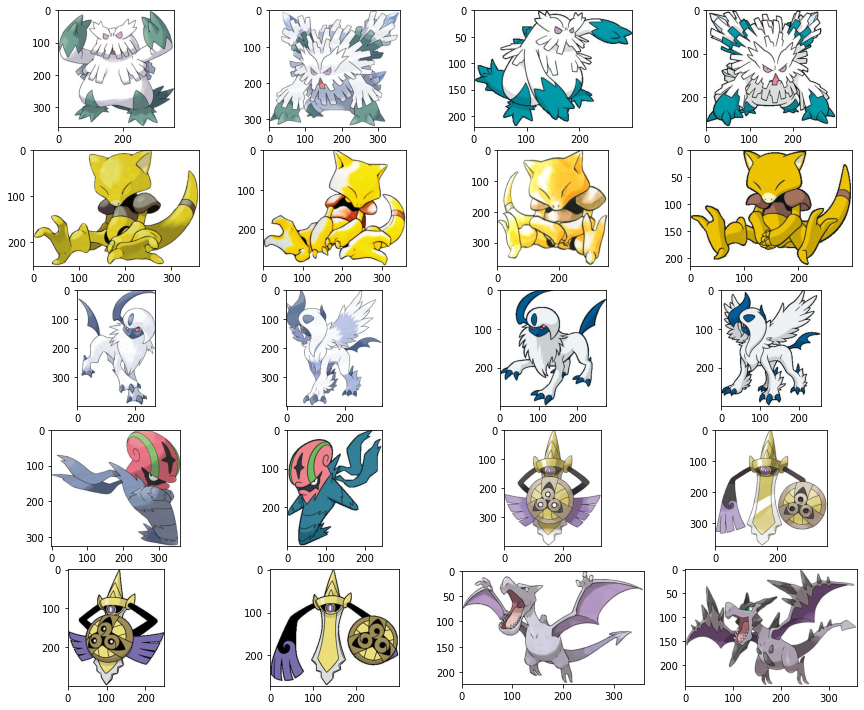

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(datset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols + 1), cols, i + 1)
        plt.imshow(img[0])

# data = torchvision.datasets.StanfordCars(root=".", download=True)
show_images(data)

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect. 

# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually. 

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [4]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Let's test it on our dataset ...

In [5]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data = dset.ImageFolder(root=dataroot,
                            transform=transforms.Compose([
                            transforms.Resize((IMG_SIZE, IMG_SIZE)),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(), # Scales data into [0,1] 
                            transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
                            ])
                        )
    # data_transforms = [
    #     transforms.Resize((IMG_SIZE, IMG_SIZE)),
    #     transforms.RandomHorizontalFlip(),
    #     transforms.ToTensor(), # Scales data into [0,1] 
    #     transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    # ]

    # data_transform = transforms.Compose(data_transforms)
    train, test = train_test_split(data, train_size=0.5, random_state=42)
    return torch.utils.data.ConcatDataset([train, test])


def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

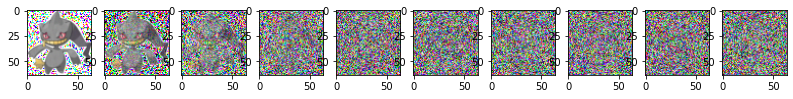

In [6]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, int(num_images+1), int((idx/stepsize) + 1))
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [9]:
from torch import nn
import math

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels) - 1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels) - 1)])
        self.atts = nn.ModuleList([Attention_block(F_g = up_channels[i+1], 
                                                   F_l = up_channels[i+1], 
                                                   F_int = up_channels[i+1] / 2)
                    for i in range(len(up_channels) - 1)])
        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for (up, att) in zip(self.ups, self.atts):
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = att(g = residual_x, x = x)
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

TypeError: ignored

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.nn import init
# import math


# class SinusoidalPositionEmbeddings(nn.Module):
#     def __init__(self, dim):
#         super().__init__()
#         self.dim = dim

#     def forward(self, time):
#         device = time.device
#         half_dim = self.dim // 2
#         embeddings = math.log(10000) / (half_dim - 1)
#         embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
#         embeddings = time[:, None] * embeddings[None, :]
#         embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
#         return embeddings


# class conv_block(nn.Module):
#     def __init__(self, ch_in, ch_out, time_emb_dim):
#         super(conv_block,self).__init__()
#         self.time_mlp =  nn.Linear(time_emb_dim, ch_out)
#         self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True)
#         self.bnorm1 = nn.BatchNorm2d(ch_out)
#         self.bnorm2 = nn.BatchNorm2d(ch_out)
#         self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True)
#         self.relu  = nn.ReLU()

#     def forward(self, x, t, ):
#         h = self.bnorm1(self.relu(self.conv1(x)))
#         # Time embedding
#         time_emb = self.relu(self.time_mlp(t))
#         # Extend last 2 dimensions
#         time_emb = time_emb[(..., ) + (None, ) * 2]
#         # Add time channel
#         h = h + time_emb
#         # Second Conv
#         h = self.bnorm2(self.relu(self.conv2(h)))
#         # Down or Upsample
#         return h

# class up_conv(nn.Module):
#     def __init__(self,ch_in,ch_out):
#         super(up_conv,self).__init__()
#         self.up = nn.Sequential(
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
# 		    nn.BatchNorm2d(ch_out),
# 			nn.ReLU(inplace=True)
#         )

#     def forward(self,x):
#         x = self.up(x)
#         return x

        

# class single_conv(nn.Module):
#     def __init__(self,ch_in,ch_out):
#         super(single_conv,self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
#             nn.BatchNorm2d(ch_out),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self,x):
#         x = self.conv(x)
#         return x

# class Attention_block(nn.Module):
#     def __init__(self,F_g,F_l,F_int):
#         super(Attention_block,self).__init__()
#         self.W_g = nn.Sequential(
#             nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
#             nn.BatchNorm2d(F_int)
#             )
        
#         self.W_x = nn.Sequential(
#             nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
#             nn.BatchNorm2d(F_int)
#         )

#         self.psi = nn.Sequential(
#             nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
#             nn.BatchNorm2d(1),
#             nn.Sigmoid()
#         )
        
#         self.relu = nn.ReLU(inplace=True)
        
#     def forward(self,g,x):
#         g1 = self.W_g(g)
#         x1 = self.W_x(x)
#         psi = self.relu(g1+x1)
#         psi = self.psi(psi)

#         return x*psi


# class AttU_Net(nn.Module):
#     def __init__(self):
#         super(AttU_Net,self).__init__()
#         time_emb_dim = 32
#         self.time_mlp = nn.Sequential(
#                 SinusoidalPositionEmbeddings(time_emb_dim),
#                 nn.Linear(time_emb_dim, time_emb_dim),
#                 nn.ReLU()
#             )
#         self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

#         self.Conv1 = conv_block(ch_in=3,ch_out=64, time_emb_dim=time_emb_dim)
#         self.Conv2 = conv_block(ch_in=64,ch_out=128, time_emb_dim=time_emb_dim)
#         self.Conv3 = conv_block(ch_in=128,ch_out=256, time_emb_dim=time_emb_dim)
#         self.Conv4 = conv_block(ch_in=256,ch_out=512, time_emb_dim=time_emb_dim)
#         self.Conv5 = conv_block(ch_in=512,ch_out=1024, time_emb_dim=time_emb_dim)

#         self.Up5 = up_conv(ch_in=1024,ch_out=512)
#         self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
#         self.Up_conv5 = conv_block(ch_in=1024, ch_out=512, time_emb_dim=time_emb_dim)

#         self.Up4 = up_conv(ch_in=512,ch_out=256)
#         self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
#         self.Up_conv4 = conv_block(ch_in=512, ch_out=256, time_emb_dim=time_emb_dim)
        
#         self.Up3 = up_conv(ch_in=256,ch_out=128)
#         self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
#         self.Up_conv3 = conv_block(ch_in=256, ch_out=128, time_emb_dim=time_emb_dim)
        
#         self.Up2 = up_conv(ch_in=128,ch_out=64)
#         self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
#         self.Up_conv2 = conv_block(ch_in=128, ch_out=64, time_emb_dim=time_emb_dim)

#         self.Conv_1x1 = nn.Conv2d(64,1,kernel_size=1,stride=1,padding=0)


#     def forward(self, x, timestep, ):
#         # encoding path
#         t = self.time_mlp(timestep)
#         x1 = self.Conv1(x, t)
#         x2 = self.Maxpool(x1)
#         x2 = self.Conv2(x2, t)
        
#         x3 = self.Maxpool(x2)
#         x3 = self.Conv3(x3, t)

#         x4 = self.Maxpool(x3)
#         x4 = self.Conv4(x4, t)

#         x5 = self.Maxpool(x4)
#         x5 = self.Conv5(x5, t)

#         # decoding + concat path
#         d5 = self.Up5(x5)
#         x4 = self.Att5(g=d5,x=x4)
#         d5 = torch.cat((x4,d5),dim=1)        
#         d5 = self.Up_conv5(d5, t)
        
#         d4 = self.Up4(d5)
#         x3 = self.Att4(g=d4,x=x3)
#         d4 = torch.cat((x3,d4),dim=1)
#         d4 = self.Up_conv4(d4, t)

#         d3 = self.Up3(d4)
#         x2 = self.Att3(g=d3,x=x2)
#         d3 = torch.cat((x2,d3),dim=1)
#         d3 = self.Up_conv3(d3, t)

#         d2 = self.Up2(d3)
#         x1 = self.Att2(g=d2,x=x1)
#         d2 = torch.cat((x1,d2),dim=1)
#         d2 = self.Up_conv2(d2, t)

#         d1 = self.Conv_1x1(d2)

#         return d1

# model = AttU_Net()
# print("Num params: ", sum(p.numel() for p in model.parameters()))
# # model


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization 
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [ ]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation 
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [ ]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, int(num_images), int(i/stepsize+1))
            show_tensor_image(img.detach().cpu())
    plt.show()            

## Training

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 500 

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()

In Table 2, we show the sample quality effects of reverse process parameterizations and training
objectives (Section 3.2). We find that the baseline option of predicting µ˜ works well only when
trained on the true variational bound instead of unweighted mean squared error, a simplified objective
akin to Eq. (14). We also see that learning reverse process variances (by incorporating a parameterized
diagonal Σθ(xt) into the variational bound) leads to unstable training and poorer sample quality
compared to fixed variances. Predicting , as we proposed, performs approximately as well as
predicting µ˜ when trained on the variational bound with fixed variances, but much better when trained
with our simplified objective.


iffusion models scale down the data with each forward process step (by a √
1 − βt factor)
so that variance does not grow when adding noise, thus providing consistently scaled inputs
to the neural net reverse process. NCSN omits this scaling factor.


In [ ]:
!pip install gdown

In [ ]:
!pip install -U --no-cache-dir gdown --pre

In [ ]:
import gdown
!gdown 1o82yVtxfDHp5R_W4HMMDN0EVqAd6bZ2C
# https://drive.google.com/file/d/1o82yVtxfDHp5R_W4HMMDN0EVqAd6bZ2C/view?usp=share_link
# https://drive.google.com/file/d/1Jis7AY_DTFeN9ATs3mvPpViAS1TmgwX3/view?usp=share_link

In [ ]:
from torch.optim import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = Adam(model.parameters(), lr=0.001)

checkpoint = torch.load('openai_diffusion.pt')
print(checkpoint)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model = model.cuda()

In [ ]:
for i in range(5):
    sample_plot_image()